# In this notebook I produce test cases for different lineshape to be used as tests in the C++ implementation

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import AdvancedBraggEdgeFitting_v2
from scipy.stats import norm
from lmfit import Model
import lmfit

from TOF_routines import tof2l, l2tof, find_first, find_last, find_nearest, savitzky_golay
from AdvancedBraggEdgeFitting_v2 import running_mean
from scipy.optimize import curve_fit

%matplotlib notebook

## Load the test data, this is the main Bragg edge of the iron powder sample used for calibration of the IMAT experiment 

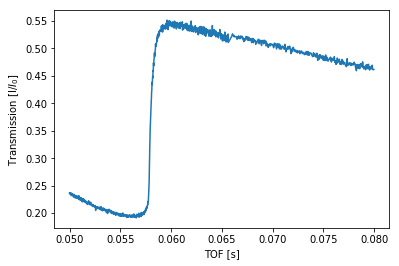

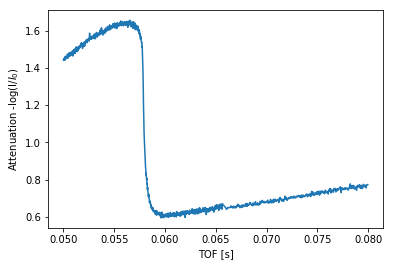

In [2]:
x = np.loadtxt('../UnitTests/test_data/x.txt') # x axis, here in TOF
y = np.loadtxt('../UnitTests/test_data/y.txt') # y axis, here in transmission

plt.figure()
plt.plot(x,y)
plt.xlabel('TOF [s]')
plt.ylabel('Transmission [I/$I_{0}$]')

logy = -np.log(y)
plt.figure()
plt.plot(x,logy)
plt.xlabel('TOF [s]')
plt.ylabel('Attenuation -log(I/$I_{0}$)')
np.savetxt('../UnitTests/test_data/logy.txt',logy)

## First produced case in the transmission and exponential function (default) 
To be tested are:
1. initial edge shape computed with the initial parameters
2. fitted parameters

[[Model]]
    Model(BraggEdgeExponential)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 194
    # data points      = 1107
    # variables        = 7
    chi-square         = 0.02510464
    reduced chi-square = 2.2822e-05
    Akaike info crit   = -11824.3815
    Bayesian info crit = -11789.3156
[[Variables]]
    t0:                 0.05773708 +/- 3.7714e-06 (0.01%) (init = 0.056568)
    alpha:              3.6402e-04 +/- 4.8113e-06 (1.32%) (init = 0.0015)
    sigma:              6.1353e-05 +/- 4.6249e-06 (7.54%) (init = 0.0001)
    a1:                 0.12457211 +/- 0.00411179 (3.30%) (init = 0.315462)
    a2:                 8.01859477 +/- 0.06075438 (0.76%) (init = 5.344784)
    a5:                 0.08703528 +/- 0.02926900 (33.63%) (init = -0.4700811)
    a6:                 17.2455669 +/- 0.54396234 (3.15%) (init = 26.92983)
    bool_transmission: -inf (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(a5, a6)       = -0.999
    C(a1,

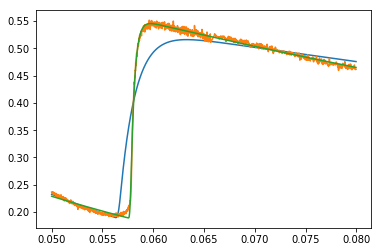

In [3]:

# initial parameters (these are taken from the initial steps in AdvancedBraggEdgeFitting)
t0=0.056568
alpha=0.0015
sigma=0.0001
a1=0.315462
a2=5.3447841
a5=-0.4700811
a6=26.92982514130

mymodel_ini=AdvancedBraggEdgeFitting_v2.BraggEdgeExponential(x,t0,alpha,sigma,a1,a2,a5,a6,True)
myedge = AdvancedBraggEdgeFitting_v2.B(x,t0,alpha,sigma,True)

term3 = AdvancedBraggEdgeFitting_v2.term3(x,t0,sigma)
term4 = AdvancedBraggEdgeFitting_v2.term4(x,t0,alpha,sigma)
term5 = AdvancedBraggEdgeFitting_v2.term5(x,t0,alpha,sigma)

gmodel = Model(AdvancedBraggEdgeFitting_v2.BraggEdgeExponential)

# This by passes the implementation of BraggEdgeFitting which is iterative and makes some steps
params = gmodel.make_params(t0=t0,sigma=sigma, alpha=alpha, a1=a1, a2=a2, a5=a5, a6=a6)
params['bool_transmission'].vary = False


result = gmodel.fit(y, params, t=x, nan_policy='propagate')
print(result.fit_report())

plt.figure()
plt.plot(x,mymodel_ini) # Initial model
plt.plot(x,y) # Data
plt.plot(x, result.best_fit) # Best fit

# np.savetxt('../test_data/x.txt',x)
# np.savetxt('../test_data/y.txt',y)

## This possibly I don't need
# np.savetxt('../test_data/edge.txt', myedge) # This is just the edge shape, without the stuff before and after
# np.savetxt('../test_data/term3.txt', term3)
# np.savetxt('../test_data/term4.txt', term4)
# np.savetxt('../test_data/term5.txt', term5)
np.savetxt('../UnitTests/test_data/ini_model_Texp.txt', mymodel_ini)

## The second test case is Transmission and linear function before and after the edge 

0.6950579360230543 -2.759274924510319 0.5660430851212845 -6.692051420263259
[[Model]]
    Model(BraggEdgeLinear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 186
    # data points      = 1107
    # variables        = 7
    chi-square         = 0.02536321
    reduced chi-square = 2.3057e-05
    Akaike info crit   = -11813.0379
    Bayesian info crit = -11777.9721
[[Variables]]
    t0:                 0.05773866 +/- 3.8260e-06 (0.01%) (init = 0.056568)
    alpha:              3.5847e-04 +/- 4.8239e-06 (1.35%) (init = 0.0015)
    sigma:              6.2354e-05 +/- 4.6161e-06 (7.40%) (init = 0.0001)
    a1:                 0.78972162 +/- 0.00209004 (0.26%) (init = 0.6950579)
    a2:                -4.07815580 +/- 0.03061434 (0.75%) (init = -2.759275)
    a5:                 0.48510798 +/- 0.00607556 (1.25%) (init = 0.5660431)
    a6:                -5.14692195 +/- 0.11283106 (2.19%) (init = -6.692051)
    bool_transmission:  1 (fixed)
[[Correlations]] (unrep

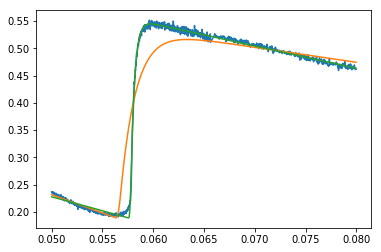

In [4]:
t0=0.056568
alpha=0.0015
sigma=0.0001

# I have to recompute the linear parameters, because the linear formulation is a bit different from the exponentials..
est_pos = find_nearest(t0,x)
x_before= x[0:est_pos]
bragg_before=y[0:est_pos]
x_after= x[est_pos+int(est_pos*0.2):-1]
bragg_after=y[est_pos+int(est_pos*0.2):-1]

# plt.figure()
# plt.plot(x_before, bragg_before)
# plt.plot(x_after, bragg_after)

[slope_before, interception_before] = np.polyfit(x_before, bragg_before, 1)
[slope_after, interception_after] = np.polyfit(x_after, bragg_after, 1)
#first guess of paramters
a2=slope_after
a5=interception_before
a6=slope_before
a1=interception_after

print(a1,a2,a5,a6)


mymodel_ini=AdvancedBraggEdgeFitting_v2.BraggEdgeLinear(x,t0,alpha,sigma,a1,a2,a5,a6,True)

np.savetxt('../UnitTests/test_data/ini_model_Tlin.txt', mymodel_ini)

plt.figure()
plt.plot(x,y)
plt.plot(x, mymodel_ini)

gmodel = Model(AdvancedBraggEdgeFitting_v2.BraggEdgeLinear)
params = gmodel.make_params(t0=t0,sigma=sigma, alpha=alpha, a1=a1, a2=a2, a5=a5, a6=a6, bool_transmission=True)
params['bool_transmission'].vary = False
result = gmodel.fit(y, params, t=x, nan_policy='propagate')
print(result.fit_report())
plt.plot(x, result.best_fit) # Best fit


## The third case is the gaussian of the gradient 
but first I will have to implement some sort of averaging in C++

In [5]:
def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x-cen)**2 / wid)

(1107,) (1107,)
[7.06365249e+02 5.79330380e-02 4.62265052e-08]
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 124
    # data points      = 1107
    # variables        = 3
    chi-square         = 768748.746
    reduced chi-square = 696.330386
    Akaike info crit   = 7249.22336
    Bayesian info crit = 7264.25159
[[Variables]]
    amp:  706.346498 +/- 8.90919586 (1.26%) (init = 500)
    cen:  0.05793304 +/- 2.2146e-06 (0.00%) (init = 0.056568)
    wid:  4.6231e-08 +/- 1.3469e-09 (2.91%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = -0.577



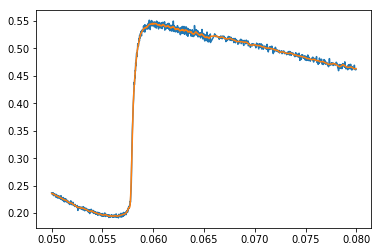

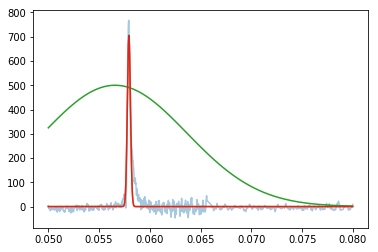

In [6]:
#Initial parameters
height = 500
t0=0.056568
sigma=0.0001

averaged = savitzky_golay(y, 31, 5)
# averaged = y
mygradient = np.gradient(averaged,x)
print(np.shape(mygradient), np.shape(y))

plt.figure()
plt.plot(x,y)
plt.plot(x,averaged)

np.savetxt('../UnitTests/test_data/smoothed_edge.txt', averaged)

# %matplotlib notebook
plt.figure()
plt.plot(x,mygradient,alpha=0.4)
np.savetxt('../UnitTests/test_data/gradient.txt', mygradient)

gmodel = Model(gaussian)
params = gmodel.make_params(cen=t0, amp=500, wid=0.0001)
# y_eval = gmodel.eval(params, x=x)

# plt.plot(x,y_eval)
ini_gauss = gaussian(x,height, t0, sigma)
np.savetxt('../UnitTests/test_data/ini_gauss.txt', ini_gauss)

best_vals, covar = curve_fit(gaussian, x, mygradient)
print(best_vals)
gaus_fit = gaussian(x,best_vals[0], best_vals[1], best_vals[2])

plt.plot(x,gaus_fit)
plt.plot(x, ini_gauss)
# computed ini_gauss
myini_gauss = height*np.exp(-(x-t0)**2/(sigma**2))
# plt.plot(x, myini_gauss)
                     
result = gmodel.fit(mygradient, params, x=x)
print(result.fit_report())

plt.plot(x, result.best_fit) # Best fit

## The fourth case is the Bragg edge model in attenuation and exponential functions 
This I don't foresee it will be really used

0.5854773231118123 8.245338500153691 0.6237067469876948 -20.09875767202516
[[Model]]
    Model(BraggEdgeExponential_Attenuation)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 272
    # data points      = 1107
    # variables        = 7
    chi-square         = 0.36223433
    reduced chi-square = 3.2930e-04
    Akaike info crit   = -8869.53429
    Bayesian info crit = -8834.46843
[[Variables]]
    t0:                 0.05788515 +/- 1.2361e-05 (0.02%) (init = 0.056568)
    alpha:              1.5583e-04 +/- 7.4186e-06 (4.76%) (init = 0.0015)
    sigma:              2.1647e-04 +/- 1.0645e-05 (4.92%) (init = 0.0001)
    a1:                 0.73414570 +/- 0.01893464 (2.58%) (init = 0.5854773)
    a2:                 5.22685127 +/- 0.32737373 (6.26%) (init = 8.245339)
    a5:                 0.44088105 +/- 0.01537015 (3.49%) (init = 0.6237067)
    a6:                -16.6111563 +/- 0.28530501 (1.72%) (init = -20.09876)
    bool_transmission:  0 (fixed)
[[Correl

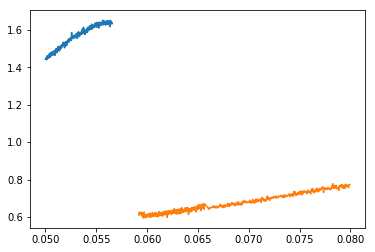

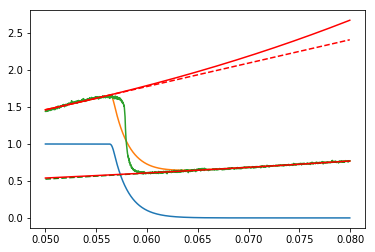

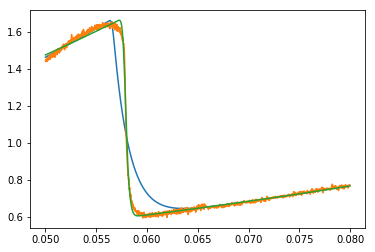

In [8]:
# This is actually to FIX!! in the actual formulation

t0=0.056568
alpha=0.0015
sigma=0.0001

est_pos = find_nearest(t0,x)
x_before= x[0:est_pos]
bragg_before=logy[0:est_pos]
x_after= x[est_pos+int(est_pos*0.4):-1]
bragg_after=logy[est_pos+int(est_pos*0.4):-1]

plt.figure()
plt.plot(x_before, bragg_before)
plt.plot(x_after, bragg_after)

[slope_before, interception_before] = np.polyfit(x_before, bragg_before, 1)
[slope_after, interception_after] = np.polyfit(x_after, bragg_after, 1)
#first guess of parameters
a2=slope_after
a5=interception_before
a6=slope_before
a1=interception_after

exp_model_before = Model(AdvancedBraggEdgeFitting_v2.exp_before)
params = exp_model_before.make_params(a5=a5, a6=a6)
result_exp_model_before = exp_model_before.fit(bragg_before,params,t=x_before)
a5=result_exp_model_before.best_values.get('a5')
a6=result_exp_model_before.best_values.get('a6')

exp_model_after = Model(AdvancedBraggEdgeFitting_v2.exp_combined)
params = exp_model_after.make_params(a1=a1, a2=a2, a5=a5, a6=a6)
params['a5'].vary = False
params['a6'].vary = False
result_exp_model_after = exp_model_after.fit(bragg_after,params,t=x_after)
a1=result_exp_model_after.best_values.get('a1')
a2=result_exp_model_after.best_values.get('a2')

print(a1,a2,a5,a6)





mymodel_ini=AdvancedBraggEdgeFitting_v2.BraggEdgeExponential_Attenuation(x,t0,alpha,sigma,a1,a2,a5,a6,False) ## This is very weird
myedge = AdvancedBraggEdgeFitting_v2.B(x,t0,alpha,sigma,False)


plt.figure()
plt.plot(x,myedge)
plt.plot(x,mymodel_ini)
plt.plot(x,logy)
plt.plot(x,interception_before+slope_before*x,'--r', label='fitted line before')
plt.plot(x,interception_after+slope_after*x,'--g', label='fitted line after')
plt.plot(x,AdvancedBraggEdgeFitting_v2.exp_before(x,a5,a6),'r', label='fitted exp after')
plt.plot(x,AdvancedBraggEdgeFitting_v2.exp_combined(x,a1,a2,a5,a6),'r', label='fitted exp combined')

gmodel = Model(AdvancedBraggEdgeFitting_v2.BraggEdgeExponential_Attenuation)

# This by passes the implementation of BraggEdgeFitting which is iterative and makes some steps
params = gmodel.make_params(t0=t0,sigma=sigma, alpha=alpha, a1=a1, a2=a2, a5=a5, a6=a6, bool_transmission=False)
params['bool_transmission'].vary = False

first_guess = gmodel.eval(params, t=x)


result = gmodel.fit(logy, params, t=x, nan_policy='propagate')
print(result.fit_report())

plt.figure()
plt.plot(x,first_guess) # Initial model
plt.plot(x,logy) # Data
plt.plot(x, result.best_fit) # Best fit

np.savetxt('../UnitTests/test_data/inimodel_Aexp.txt', mymodel_ini)

# The fifth case is the Bragg edge model in attenuation and linear functions


-0.12174127292834003 31.65784345829804 0.3221873247378136 5.2674654703300545
[[Model]]
    Model(BraggEdgeLinear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 360
    # data points      = 1107
    # variables        = 7
    chi-square         = 0.35866594
    reduced chi-square = 3.2606e-04
    Akaike info crit   = -8880.49347
    Bayesian info crit = -8845.42760
[[Variables]]
    t0:                 0.05788538 +/- 1.2619e-05 (0.02%) (init = 0.056568)
    alpha:              1.5772e-04 +/- 7.5232e-06 (4.77%) (init = 0.0015)
    sigma:              2.1684e-04 +/- 1.0740e-05 (4.95%) (init = 0.0001)
    a1:                 0.14975358 +/- 0.00746697 (4.99%) (init = -0.1217413)
    a2:                 7.67236371 +/- 0.10999636 (1.43%) (init = 31.65784)
    a5:                 0.15162227 +/- 0.02393800 (15.79%) (init = 0.3221873)
    a6:                 26.4337443 +/- 0.44559721 (1.69%) (init = 5.267465)
    bool_transmission: -inf (fixed)
[[Correlations]] (un

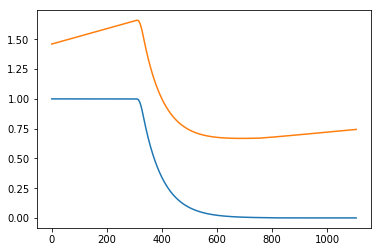

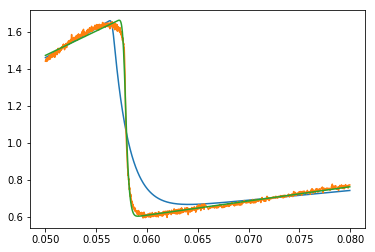

In [9]:
t0=0.056568
alpha=0.0015
sigma=0.0001

est_pos = find_nearest(t0,x)
x_before= x[0:est_pos]
bragg_before=logy[0:est_pos]
x_after= x[est_pos+int(est_pos*0.2):-1]
bragg_after=logy[est_pos+int(est_pos*0.2):-1]

[slope_before, interception_before] = np.polyfit(x_before, bragg_before, 1)
[slope_after, interception_after] = np.polyfit(x_after, bragg_after, 1)
#first guess of paramters
# a2 = slope_after
# a5 = interception_before
# a6 = slope_before
# a1 = interception_after

a6 = slope_after
a1 = interception_before
a2 = slope_before
a5 = interception_after


print(a1,a2,a5,a6)

mymodel_ini=AdvancedBraggEdgeFitting_v2.BraggEdgeLinear(x,t0,alpha,sigma,a1,a2,a5,a6,False)
myedge = AdvancedBraggEdgeFitting_v2.B(x,t0,alpha,sigma,False)

plt.figure()
plt.plot(myedge)
plt.plot(mymodel_ini)

gmodel = Model(AdvancedBraggEdgeFitting_v2.BraggEdgeLinear)

# This by passes the implementation of BraggEdgeFitting which is iterative and makes some steps
params = gmodel.make_params(t0=t0,sigma=sigma, alpha=alpha, a1=a1, a2=a2, a5=a5, a6=a6, bool_tranmission='False')
params['bool_transmission'].vary = False


result = gmodel.fit(logy, params, t=x, nan_policy='propagate')
print(result.fit_report())

plt.figure()
plt.plot(x,mymodel_ini) # Initial model
plt.plot(x,logy) # Data
plt.plot(x, result.best_fit) # Best fit

np.savetxt('../UnitTests/test_data/inimodel_Alinear.txt', mymodel_ini)

## Here I produced the data that were used for testing the numerical gradient implementation 

In [ ]:

print(np.shape(x))
print(x[1::100])
print(y[1::100])
print(np.gradient(y[1::100], x[1::100]))

plt.figure()
plt.plot(x[1::100], y[1::100])

plt.figure()
plt.plot(x[1::100], np.gradient(y[1::100]))

## Here I test some method for edge height computation 

In [ ]:
plt.figure()
plt.plot(x, result.best_fit)
print(result.best_values.get('t0'))
edge_point = result.best_values.get('t0')
first_point = result.best_values.get('t0')-1.96*result.best_values.get('sigma')
second_point = result.best_values.get('t0')+1.96*result.best_values.get('sigma')+5*result.best_values.get('alpha')
plt.plot(first_point, result.best_fit[find_nearest(x,first_point)],'*')
plt.plot(second_point, result.best_fit[find_nearest(x,second_point)],'*')
plt.plot(edge_point, result.best_fit[find_nearest(x,edge_point)],'*')



print(result.best_values.get('t0'), result.best_values.get('sigma'), result.best_values.get('alpha'))

In [ ]:
plt.figure()
plt.plot(x, np.gradient(result.best_fit))
plt.plot(x, np.zeros(np.size(result.best_fit)))
plt.plot(x[np.gradient(result.best_fit)==0], (np.gradient(result.best_fit)[np.gradient(result.best_fit)==0]))